In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

# Lecture des données

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from pathlib import Path
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from functools import reduce

from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/content/drive/MyDrive/Colab Notebooks/main_tpe.ipynb
/content/drive/MyDrive/Colab Notebooks/caption.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled0.ipynb
/content/drive/MyDrive/Colab Notebooks/1- main.ipynb
/content/drive/MyDrive/Colab Notebooks/Assignment #2 - Text-to-Speech.ipynb
/content/drive/MyDrive/Colab Notebooks/credit-card-fraud-detection.ipynb
/content/drive/MyDrive/Colab Notebooks/Copie 2 de EncoderDecoder time series
/content/drive/MyDrive/Colab Notebooks/EncoderDecoder time series.ipynb
/content/drive/MyDrive/Colab Notebooks/Copie 1 de EncoderDecoder time series
/content/drive/MyDrive/Colab Notebooks/quarter_dataset_10k/156967462_72db9b722c.jpg
/content/drive/MyDrive/Colab Notebooks/quarter_dataset_10k/2211593099_4a4f1c85d2.jpg
/content/drive/MyDrive/Colab Notebooks/quarter_dataset_10k/1388970365_162edcceb4.jpg
/content/drive/MyDrive/Colab Notebooks/quarter_dataset_10k/1557451043_f5c91ff6f4.jpg
/content/drive/MyDrive/Colab Notebooks/quarter_dataset_10k/2077079696_0

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
data = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Dataset/smartflow_dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   year         int64  
 1   month        int64  
 2   day          int64  
 3   timestamps   float64
 4   humidity     float64
 5   light        int64  
 6   pir          int64  
 7   sound        int64  
 8   temperature  float64
dtypes: float64(3), int64(6)
memory usage: 206.0 MB


In [6]:
data.head()

,year,month,day,timestamps,humidity,light,pir,sound,temperature
0,2021,8,29,1.630282e+09,1.0,3,0,4,22.2
1,2021,8,29,1.630282e+09,1.0,3,0,3,22.2
2,2021,8,29,1.630282e+09,1.0,3,0,3,22.2
3,2021,8,29,1.630282e+09,1.0,3,0,3,22.2
4,2021,8,29,1.630282e+09,1.0,3,0,3,22.2


# Vérification des anomalies

In [7]:
data_statistic = data[['humidity', 'light', 'pir', 'sound', 'temperature']]

In [8]:
data_statistic.skew()

humidity        1.395194
light           0.485866
pir            15.661641
sound           3.497891
temperature     2.741768
dtype: float64

In [9]:
data.shape

(3000000, 9)

In [10]:
data.index

RangeIndex(start=0, stop=3000000, step=1)

# TEMPERATURE SENSOR

In [11]:
df_temp = data.drop(['year', 'month', 'day','humidity', 'light', 'pir','sound'], axis=1)
df_temp

,timestamps,temperature
0,1.630282e+09,22.2
1,1.630282e+09,22.2
2,1.630282e+09,22.2
3,1.630282e+09,22.2
4,1.630282e+09,22.2
...,...,...
2999995,1.650774e+09,17.3
2999996,1.650774e+09,17.3
2999997,1.650774e+09,17.3
2999998,1.650774e+09,17.3


In [12]:
df_temp['temperature'].min()

0.0

In [13]:
df_temp['temperature'].max()

219.253

# 

# Labelisation

In [14]:
def fakeData(x):
    if (x>=31):
        x=x-10 
    elif (x>=-19):
        x=x-9 
    elif  (x>=9):
        x=x-8 
    elif (x>=26):
        x=x-7 
    elif (x>=-19):
        x=x-6 
    else:
        x=x-5 
    return x

In [15]:
df_temp['temperature'] = df_temp['temperature'].apply(fakeData)
df_temp.head()

,timestamps,temperature
0,1.630282e+09,13.2
1,1.630282e+09,13.2
2,1.630282e+09,13.2
3,1.630282e+09,13.2
4,1.630282e+09,13.2


In [16]:
def LabelData(x):
    if x>=-10 and x<=30:
        label = 0 
    else:
        label = 1 
    return label

In [17]:
df_temp['Class'] = df_temp['temperature'].apply(LabelData)
df_temp.head()

,timestamps,temperature,Class
0,1.630282e+09,13.2,0
1,1.630282e+09,13.2,0
2,1.630282e+09,13.2,0
3,1.630282e+09,13.2,0
4,1.630282e+09,13.2,0


In [18]:
#def LabelData(x):
#    if x>=10 and x<=30:
#        label = 0 #'Peak+'
#    else:
#        label = 1 #'Noise'
#    return label

# Regardons combien nous avons de données frauduleuses :

In [19]:
df_temp.groupby(['Class']).count()

,timestamps,temperature
Class,,
0,2994727,2994727
1,5273,5273


In [20]:
df_temp

,timestamps,temperature,Class
0,1.630282e+09,13.2,0
1,1.630282e+09,13.2,0
2,1.630282e+09,13.2,0
3,1.630282e+09,13.2,0
4,1.630282e+09,13.2,0
...,...,...,...
2999995,1.650774e+09,8.3,0
2999996,1.650774e+09,8.3,0
2999997,1.650774e+09,8.3,0
2999998,1.650774e+09,8.3,0


In [21]:
pourcentage_1 = 100*(5273/3000000)
pourcentage_1

0.17576666666666668

In [22]:
pourcentage_2 = 100*(5273/2994727)
pourcentage_2

0.17607614984604605

In [23]:
df_temp

,timestamps,temperature,Class
0,1.630282e+09,13.2,0
1,1.630282e+09,13.2,0
2,1.630282e+09,13.2,0
3,1.630282e+09,13.2,0
4,1.630282e+09,13.2,0
...,...,...,...
2999995,1.650774e+09,8.3,0
2999996,1.650774e+09,8.3,0
2999997,1.650774e+09,8.3,0
2999998,1.650774e+09,8.3,0


# Préparation des données

In [24]:
from sklearn.utils import shuffle
df_temp = shuffle(df_temp)
df_temp

,timestamps,temperature,Class
292960,1.647727e+09,11.5,0
2459054,1.647336e+09,10.7,0
518451,1.646687e+09,11.4,0
964759,1.646764e+09,11.8,0
290934,1.646778e+09,11.0,0
...,...,...,...
2182018,1.647342e+09,13.1,0
1544150,1.645715e+09,12.8,0
2580095,1.626089e+09,15.4,0
2728453,1.649836e+09,13.2,0


In [25]:
df_temp = df_temp.drop(['timestamps'], axis=1)
df_temp

,temperature,Class
292960,11.5,0
2459054,10.7,0
518451,11.4,0
964759,11.8,0
290934,11.0,0
...,...,...
2182018,13.1,0
1544150,12.8,0
2580095,15.4,0
2728453,13.2,0


count    3.000000e+06
mean     1.401251e+01
std      4.939969e+00
min     -9.000000e+00
25%      1.170000e+01
50%      1.420000e+01
75%      1.630000e+01
max      2.092530e+02
Name: temperature, dtype: float64


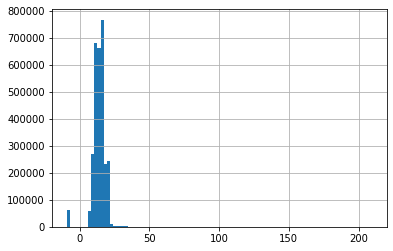

In [26]:
## Histogramme des temperatures avant normalisation
df = df_temp['temperature']
print(df.describe())
df.hist(bins=100)

In [27]:
df_temp

,temperature,Class
292960,11.5,0
2459054,10.7,0
518451,11.4,0
964759,11.8,0
290934,11.0,0
...,...,...
2182018,13.1,0
1544150,12.8,0
2580095,15.4,0
2728453,13.2,0


In [28]:
# Normalisation des temperatures
scaler = StandardScaler()
df_temp['temperature'] = scaler.fit_transform(df_temp['temperature'].values.reshape(-1, 1))

count    3.000000e+06
mean     6.253463e-16
std      1.000000e+00
min     -4.658433e+00
25%     -4.681230e-01
50%      3.795307e-02
75%      4.630570e-01
max      3.952262e+01
Name: temperature, dtype: float64


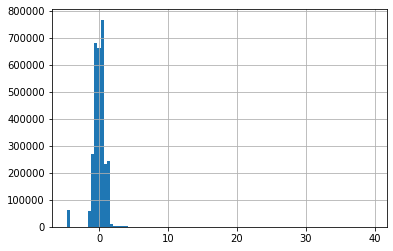

In [29]:
# Histogramme des temperatures après normalisation
df = df_temp['temperature']
print(df.describe())
df.hist(bins=100)

In [30]:
df_temp

,temperature,Class
292960,-0.508609,0
2459054,-0.670553,0
518451,-0.528852,0
964759,-0.447880,0
290934,-0.609824,0
...,...,...
2182018,-0.184720,0
1544150,-0.245450,0
2580095,0.280870,0
2728453,-0.164477,0


In [31]:
# Séparation des données d'entrainement et de test

x_entrainement, x_test = train_test_split(df_temp, test_size=0.2, random_state=0)
x_entrainement = x_entrainement.drop(['Class'], axis=1)
y_test = x_test['Class']
x_test = x_test.drop(['Class'], axis=1)
x_entrainement = x_entrainement.values
x_test = x_test.values
x_entrainement.shape

(2400000, 1)

#  Construction du modèle

Ce modèle est un modèle standard d'auto-encodeur à quatre couches :
Une couche d'entrée à 14 neurones, avec une fonction d'activation de type tanh
Une première couche cachées de 14/2 = 7 neurones, avec une fonction d'activation de type relu
Une deuxième couche cachée de 14/2 = 7 neurones, avec une fonction d'activation de type tanh
Une couche de sortie à 29 neurones (même dimension que les données d'entrées), avec une fonction d'activation de type relu



In [32]:
dimension_entrees = x_entrainement.shape[1]
dimension_encodeur = 14

model = Sequential()
model.add(Dense(dimension_encodeur, activation="tanh", input_shape=(dimension_entrees,)))
model.add(Dense(int(dimension_encodeur /2), activation="relu"))
model.add(Dense(int(dimension_encodeur /2), activation='tanh'))
model.add(Dense(dimension_entrees, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                28        
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


#  Entrainement du modèle


In [ ]:
nb_iterations = 60
batch_size = 30

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

history = model.fit(x_entrainement, x_entrainement,
                    epochs=nb_iterations,
                    batch_size=batch_size,
                    validation_data=(x_test, x_test),
                    verbose=1)

autoencoder = model

Epoch 1/60
80000/80000 [==============================] - 156s 2ms/step - loss: 0.6247 - acc: 0.0000e+00 - val_loss: 0.5872 - val_acc: 0.0000e+00
Epoch 2/60
80000/80000 [==============================] - 147s 2ms/step - loss: 0.5868 - acc: 0.0000e+00 - val_loss: 0.5828 - val_acc: 0.0000e+00
Epoch 3/60
80000/80000 [==============================] - 175s 2ms/step - loss: 0.5859 - acc: 0.0000e+00 - val_loss: 0.5828 - val_acc: 0.0000e+00
Epoch 4/60
80000/80000 [==============================] - 153s 2ms/step - loss: 0.5851 - acc: 0.0000e+00 - val_loss: 0.5833 - val_acc: 0.0000e+00
Epoch 5/60
80000/80000 [==============================] - 153s 2ms/step - loss: 0.5854 - acc: 0.0000e+00 - val_loss: 0.5828 - val_acc: 0.0000e+00
Epoch 6/60
80000/80000 [==============================] - 158s 2ms/step - loss: 0.5851 - acc: 0.0000e+00 - val_loss: 0.5829 - val_acc: 0.0000e+00
Epoch 7/60
80000/80000 [==============================] - 149s 2ms/step - loss: 0.5850 - acc: 0.0000e+00 - val_loss: 0.5836 

#  Performances du modèle

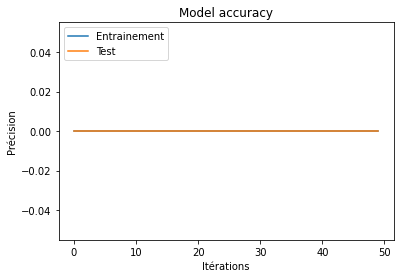

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Précision')
plt.xlabel('Itérations')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

# Structure du modèle et calcul de l'erreur de prédiction

In [36]:
x_test

array([[ 0.60475833],
       [ 0.48330006],
       [ 0.15941134],
       ...,
       [ 0.60475833],
       [-0.71103958],
       [-0.42763696]])

#  Prédictions

Les prédictions sont effectuées sur les données de tests. L'erreur quadratique moyenne (mean-squared error - MSE) est calculés entre les tests et les prédictions. Si cette erreur est grande, c'est une potentielle anomalie et donc une fraude potentielle. Bien sûr, cela n'est pas parfait et il y a des faux-positifs (et des faux négatifs) !


In [37]:
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'erreur_reconstruction': mse, 'label': y_test})

In [38]:
x_test.shape

(600000, 1)

In [39]:
predictions
mse

array([4.26051737e-07, 2.22991907e-07, 5.89970671e-07, ...,
       4.26051737e-07, 5.05577290e-01, 1.82873367e-01])

In [40]:
error_df.head()

,erreur_reconstruction,label
2929857,4.260517e-07,0
778839,2.229919e-07,0
2957294,5.899707e-07,0
1810664,3.878792e-08,0
1449953,1.337230e+00,0


# Affichage de l'erreur de reconstruction
L'erreur de reconstruction est affichée pour chaque échantillon. Seuls 50000 échantillons sont affichés, mais les données affichées sont tirées au hasard.

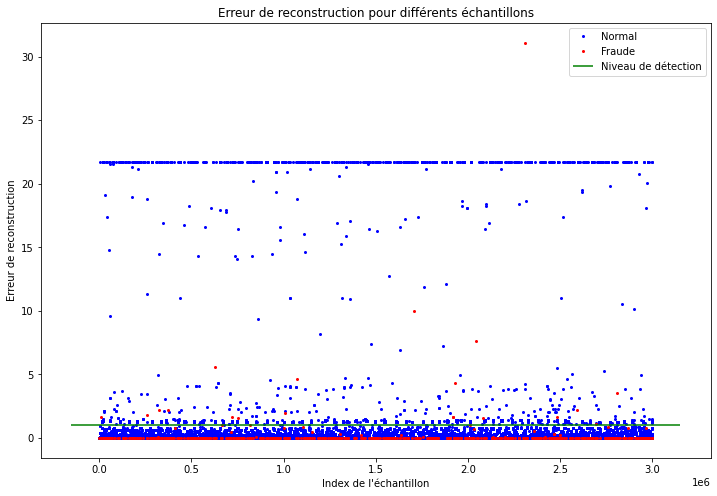

In [41]:
niveau_detection = 1

groups = error_df.groupby('label')
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in groups:
    ax.plot(group.index, group.erreur_reconstruction, marker='o', ms=2.0, linestyle='',
            label = "Fraude" if name == 1 else "Normal",
            color = "red" if name == 1 else "blue")
ax.hlines(niveau_detection, ax.get_xlim()[0], ax.get_xlim()[1], colors="green", zorder=100, label='Niveau de détection')
ax.legend()
plt.title("Erreur de reconstruction pour différents échantillons")
plt.ylabel("Erreur de reconstruction")
plt.xlabel("Index de l'échantillon")
plt.show();

#  Analyse

Comme nous connaissons les anomalies, nous pouvons afficher et calculer le nombre de faux positifs. Dans l'idéal, il faudrait que leur nombre soit très faible, mais notre modèle est imparfait...


In [42]:
transactions_normales = error_df[error_df['label'] == 0]
transactions_frauduleuses = error_df[error_df['label'] == 1]

In [43]:
print('Transactions normales : %d, Transactions frauduleuse : %d' % (len(transactions_normales), len(transactions_frauduleuses)))

Transactions normales : 598928, Transactions frauduleuse : 1072


In [44]:
transactions_frauduleuses

,erreur_reconstruction,label
1197266,0.001041,1
78820,0.000015,1
2355642,0.000141,1
2274846,0.000035,1
2388501,0.000059,1
...,...,...
905734,0.000068,1
2388315,0.000051,1
2355630,0.000141,1
1331693,0.001800,1


In [45]:
vraies_transactions_frauduleuses = len(transactions_frauduleuses[transactions_frauduleuses['erreur_reconstruction'] >= niveau_detection])
vraies_transactions_normales = len(transactions_normales[transactions_normales['erreur_reconstruction'] < niveau_detection])

faux_positifs = len(transactions_normales[transactions_normales['erreur_reconstruction'] >= niveau_detection])
faux_negatifs = len(transactions_frauduleuses[transactions_frauduleuses['erreur_reconstruction'] < niveau_detection])

print('Faux positifs: %d, Vraies transactions frauduleuses: %d' % (faux_positifs, vraies_transactions_frauduleuses))
print('Faux négatifs : %d, Vraies transactions normales: %d' % (faux_negatifs, vraies_transactions_normales))

Faux positifs: 25064, Vraies transactions frauduleuses: 23
Faux négatifs : 1049, Vraies transactions normales: 573864


# Matrice de synthèse

La matrice de synthèse ci-dessous permet d'avoir une vue d'ensemble des résultats obtenus.


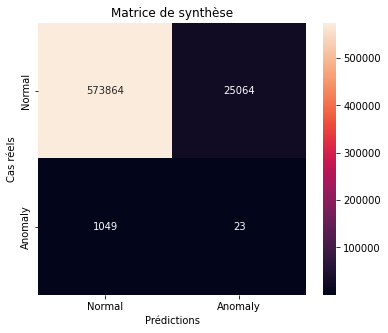

In [46]:
labels = ["Normal", "Anomaly"]

y_pred = [1 if e > niveau_detection else 0 for e in error_df.erreur_reconstruction.values]
conf_matrix = confusion_matrix(error_df['label'], y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Matrice de synthèse")
plt.ylabel('Cas réels')
plt.xlabel('Prédictions')
plt.show()

In [47]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
autoencoder.save('/content/drive/MyDrive/Colab Notebooks/Dataset/3atoencoder.h5') 

In [49]:
#new_model = tf.keras.models.load_model('atoencoder.h5')


In [50]:
#new_model.summary()